Création d'un graphe acyclique orienté pour comprendre le lien entre les différentes variables

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import FancyArrowPatch
import pandas as pd

df_merge=pd.read_pickle("Toutes_les_df_agregees/df_tous_pays.pkl")

calcul de la corrélation entre les résultats aux jeux olympiques et paralympiques

In [3]:
corr_jo_jp = (
    df_merge[['total_medailles_olympiques', 'total_medailles_paralympiques']]
    .dropna()
    .corr()
    .loc['total_medailles_olympiques', 'total_medailles_paralympiques']
)

print(f"Corrélation JO ↔ JP : {corr_jo_jp:.3f}")

Corrélation JO ↔ JP : 0.824


création et affichage du graphe explicatif

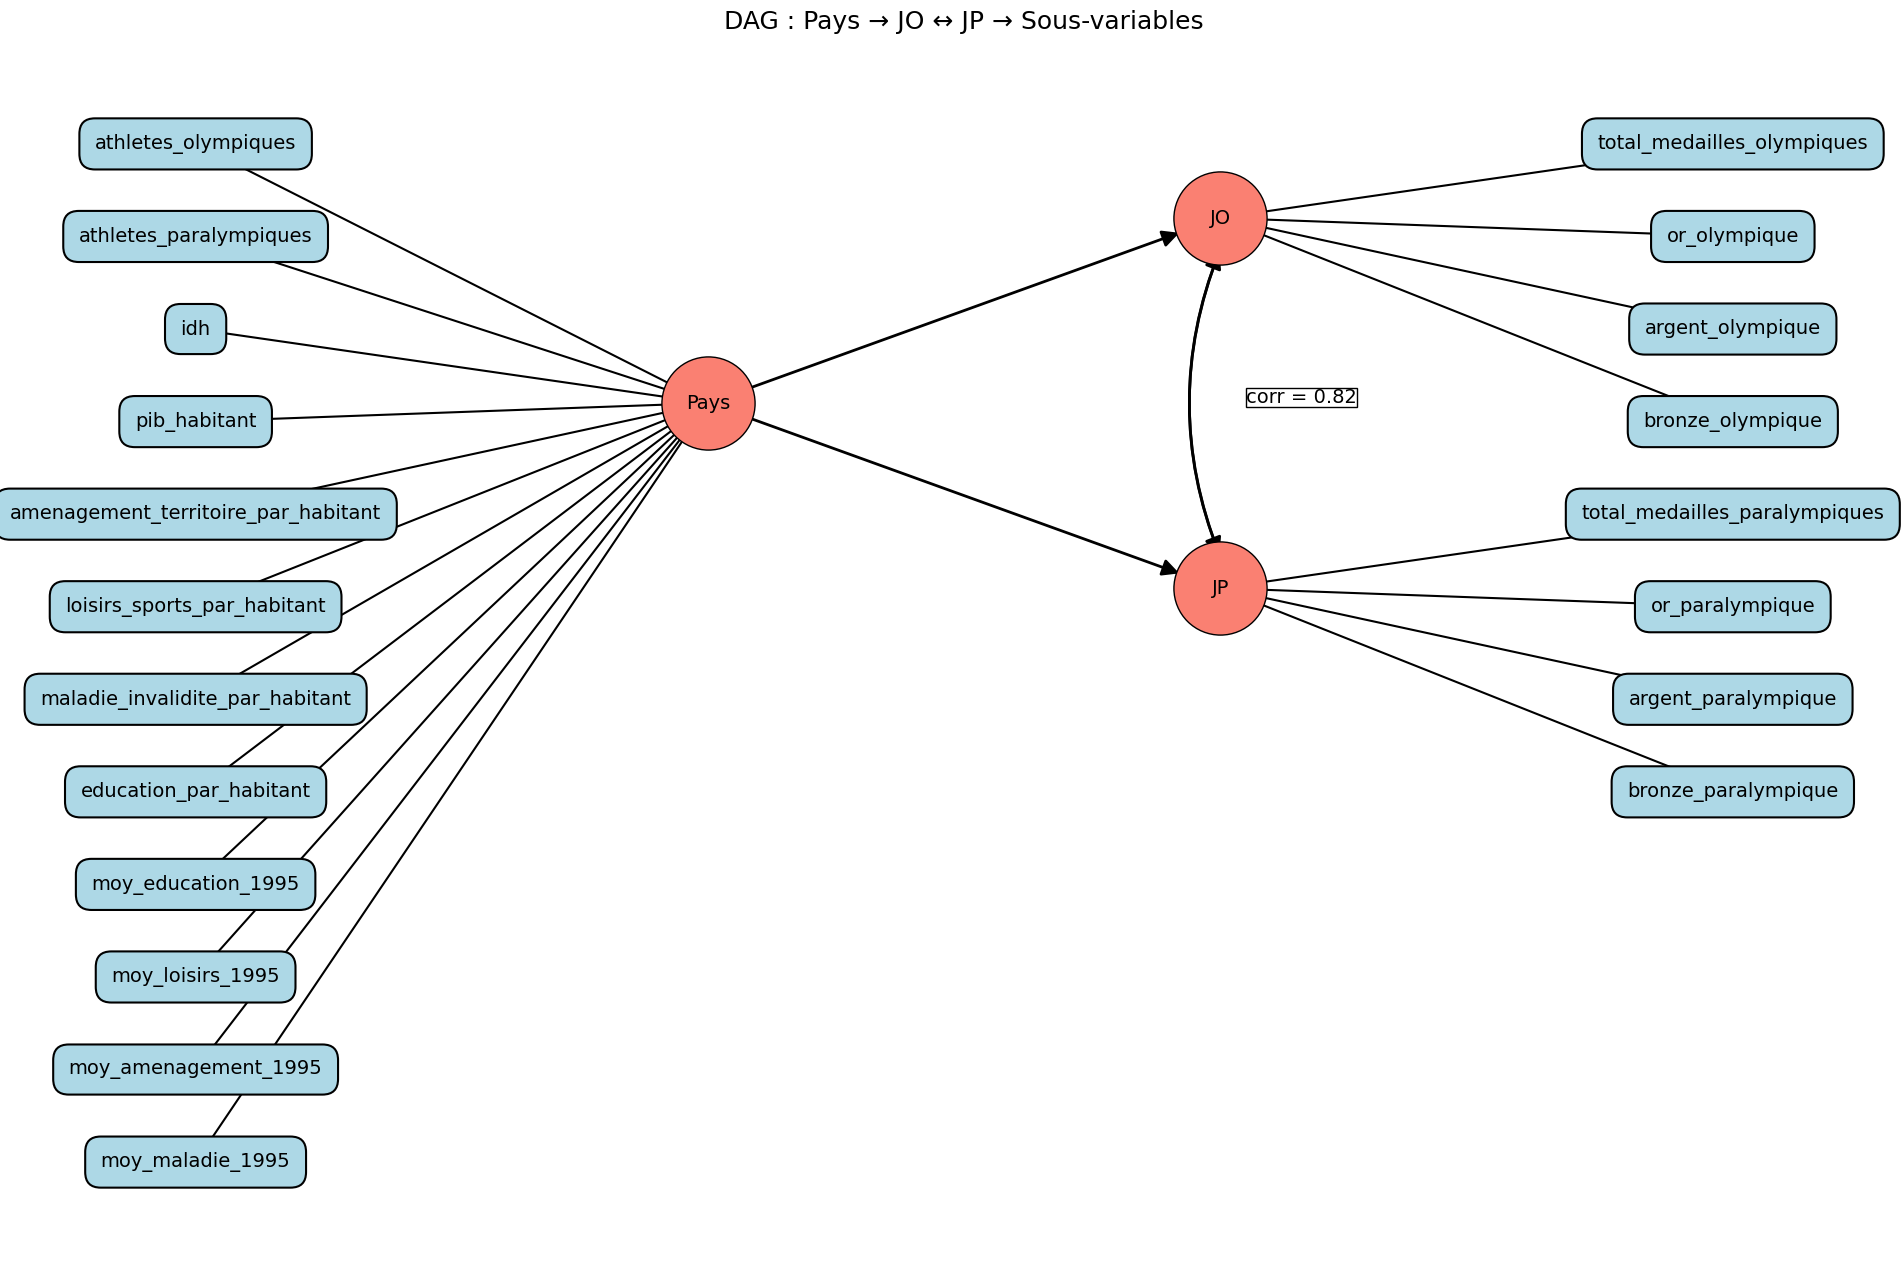

In [ ]:
G = nx.DiGraph()

main_nodes = ["Pays", "JO", "JP"]
jo_vars = ["total_medailles_olympiques", "or_olympique", "argent_olympique", "bronze_olympique"]
jp_vars = ["total_medailles_paralympiques", "or_paralympique", "argent_paralympique", "bronze_paralympique"]
pays_vars = [
    "athletes_olympiques",
    "athletes_paralympiques",
    "idh",
    "pib_habitant",
    "amenagement_territoire_par_habitant",
    "loisirs_sports_par_habitant",
    "maladie_invalidite_par_habitant",
    'education_par_habitant',
    'moy_education_1995',
    'moy_loisirs_1995',
    'moy_amenagement_1995',
    'moy_maladie_1995'
]

G.add_nodes_from(main_nodes + jo_vars + jp_vars + pays_vars)

edges_jo = [("JO", v) for v in jo_vars]
edges_jp = [("JP", v) for v in jp_vars]
edges_pays = [("Pays", v) for v in pays_vars]

# -----------------------------
# Positions des nœuds
# -----------------------------
pos = {
    "Pays": np.array([0, 0]),
    "JO": np.array([4, 2]),
    "JP": np.array([4, -2])
}

for i, v in enumerate(jo_vars):
    pos[v] = np.array([8, 2 + 0.8 - i*1.0])
for i, v in enumerate(jp_vars):
    pos[v] = np.array([8, -1.2 - i*1.0])
for i, v in enumerate(pays_vars):
    pos[v] = np.array([-4, 2 + 0.8 - i*1.0])

# -----------------------------
# Affichage
# -----------------------------
plt.figure(figsize=(24, 16))
ax = plt.gca()

# --- Sous-variables arêtes normales ---
nx.draw_networkx_edges(G, pos, edgelist=edges_jo + edges_jp + edges_pays,
                       arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5, edge_color="black")

# --- Ronds principaux ---
node_size_main = 4500
nx.draw_networkx_nodes(G, pos, nodelist=main_nodes, node_color="salmon",
                       node_shape="o", node_size=node_size_main, edgecolors="black")
nx.draw_networkx_labels(G, pos, labels={n: n for n in main_nodes}, font_size=14)

# --- Rectangles sous-variables ---
def draw_box(label, xy):
    ax.text(xy[0], xy[1], label, ha="center", va="center",
            fontsize=14,
            bbox=dict(boxstyle="round,pad=0.8", facecolor="lightblue",
                      edgecolor="black", linewidth=1.5))
for v in jo_vars + jp_vars + pays_vars:
    draw_box(v, pos[v])

# -----------------------------
# Flèches principales avec ajustement pour toucher les bords des cercles
# -----------------------------
def draw_arrow(src, dst, rad=0, color='black'):
    # Calcul décalage pour toucher bord
    start = pos[src]
    end = pos[dst]
    vec = end - start
    length = np.linalg.norm(vec)
    # rayon du cercle
    r = np.sqrt(node_size_main)/200  # ajusté empiriquement
    # décalage start/end
    start_adj = start + vec*(r/length)
    end_adj = end - vec*(r/length)
    arrow = FancyArrowPatch(start_adj, end_adj,
                            connectionstyle=f"arc3,rad={rad}",
                            arrowstyle='-|>', mutation_scale=25,
                            color=color, linewidth=2)
    ax.add_patch(arrow)

# Pays → JO et JP
draw_arrow("Pays", "JO")
draw_arrow("Pays", "JP")

# Double flèche JO ↔ JP
draw_arrow("JO", "JP", rad=0.2)
draw_arrow("JP", "JO", rad=-0.2)

# Étiquette corrélation
ax.text((pos["JO"][0] + pos["JP"][0])/2 + 0.2,
        (pos["JO"][1] + pos["JP"][1])/2,
        f"corr = {corr_jo_jp:.2f}",
        fontsize=14,
        bbox=dict(facecolor="white", edgecolor="black", pad=0.3))

plt.title("DAG : Liens entre nos variables", fontsize=18)
plt.axis("off")
plt.show()
